# REDES NEURONALES RECURRENTES (RNN)

---

RNN para identificar la intensidad de odio en mensajes escritos en las redes sociales. Esta actividad forma parte del proyecto transversal del Máster, ¡así que seguro que ya estás familiarizado/a con el dataset!

El dataset a utilizar consiste en 12280 mensajes de odio. Los mensajes pueden pertenecer a cinco categorias (numeradadas del 1 al 5), siendo 1 la menor intensidadd y 5 la mayor intensidad de odio del mensaje. El dataset ya ha sido procesado para eliminar ciertos caracteres que podrían darte problemas y para utilizar una codificación más amigable.

Empezamos, como siempre, incluyendo todo lo que vamos a necesitar. Según lo que vayas a hacer, es posible que necesites incluir alguna librería extra.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
%pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GenisPc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GenisPc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cargamos el dataset. Lo encontrarás adjunto a este Notebook, al descargar la actividad del Campus Virtual.

In [2]:
# Leemos el fichero
data = pd.read_csv('dataset.csv', sep=";", encoding='utf-8')
# Mostramos las 5 primeras filas
data.head()

,CONTENIDO A ANALIZAR,INTENSIDAD
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Cambiamos el nombre de las features para hacer su manejo más amigable:

In [3]:
data = data.rename(columns={'CONTENIDO A ANALIZAR': 'mensaje', 'INTENSIDAD': 'intensidad'})
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Mostramos información básica para saber a qué nos enfrentamos:

In [4]:
data.shape

(12279, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12279 entries, 0 to 12278
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mensaje     12279 non-null  object
 1   intensidad  12279 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ KB


Mostramos ahora la distribución de mensajes de acuerdo a su intensidad. Verás rápidamente que estamos en problemas: hay un gran desbalanceo.

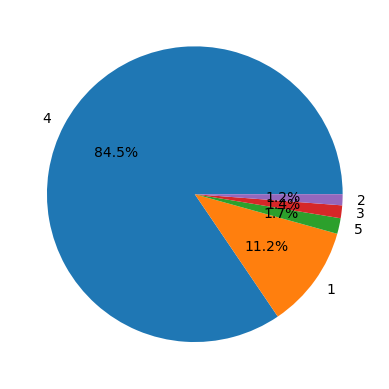

In [6]:
plt.pie(data['intensidad'].value_counts().values,
        labels = data['intensidad'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Para hacer todo más sencillo y evitar asociaciones indeseadas, vamos a trabajar solo con minúsculas. Además, quitamos los signos de puntuación de los mensajes

In [7]:
# Convertimos a minúsculas
data['mensaje'] = data['mensaje'].map(lambda x: x.lower())

# Función para eliminar signos de puntuación
def eliminar_signos(texto):
    return re.sub(f"[{re.escape(string.punctuation)}]", "", texto)

# Aplicamos la función al dataset
data['mensaje'] = data['mensaje'].map(eliminar_signos)
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso el supremo se dedi...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,preguntárselo al fracasado media carrera en 6 ...,4


Eliminamos las "stopwords" o palabras vacías. Las stopwords son palabras comunes que, en general, no contienen información relevante para el análisis de texto y suelen ser filtradas antes de procesar los datos. Ejemplos típicos de stopwords en español son: "el", "la", "los", "las", "un", "una", "de", "y", "o", etc.

In [8]:
# Obtenemos las stopwords en español
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

# Definimos una función para eliminar stopwords y lematizar
def filtrar_palabras(texto):
    palabras_filtradas = []
    for palabra in texto.split():
        if palabra not in stop_words:
            palabra_lema = lemmatizer.lemmatize(palabra)
            palabras_filtradas.append(palabra_lema)
    return ' '.join(palabras_filtradas)

# Aplicamos la función
data['mensaje'] = data['mensaje'].apply(filtrar_palabras)
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido presiden...,3
1,habrí­a reabrir caso supremo dedica proteger s...,3
2,parece exagerado pedir tres años prisión cifue...,3
3,parece delincuentes niegan evidencias pruebas ...,3
4,preguntárselo fracasado medium carrera 6 me má...,4


Creamos los conjuntos de entrenamiento y de test:

In [9]:
X = data['mensaje']
y = data['intensidad']

# Dividimos el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertimos a numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Asegurándonos de que las etiquetas estén en el rango de 0 a 4
y_train = y_train - 1  # Si las etiquetas están comenzando en 1, restamos 1
y_test = y_test - 1    # Igual para las etiquetas de prueba

# Creamos datasets de TensorFlow
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Mostramos un mensaje y su intensidad, simplemente para ver que todo va bien:

In [10]:
# for men, inte in train_dataset.take(5):
#   print('mensaje: ', men.numpy())
#   print('nivel de odio: ', inte.numpy())

Mezclamos los datos de forma aleatoria:

In [11]:
X_train[0]

'tarado abascal dice gran lider tarado trump'

In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [13]:
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
# for men, inte in train_dataset.take(1):
#   print('mensaje: ', men.numpy()[:3])
#   print()
#   print('nivel de odio: ', inte.numpy()[:3])

# Ejercicio

Construye una RNN que pueda detectar el nivel de odio de un mensaje.

# Procesamiento de Datos Textuales para Modelos de TensorFlow

Este flujo de procesamiento está diseñado para convertir datos textuales en un formato numérico comprensible por modelos de aprendizaje profundo, específicamente en TensorFlow. El objetivo principal es preparar los datos de manera eficiente, desde la transformación del texto hasta la organización en lotes listos para el entrenamiento y evaluación.

## Proceso General

1. **Vectorización del Texto**: 
   Se utiliza una capa de TextVectorization que transforma las secuencias de texto en vectores de índices enteros. Esto convierte palabras en números basados en un vocabulario adaptado al conjunto de datos de entrenamiento, asegurando consistencia y manejabilidad.

2. **Adaptación al Vocabulario**:
   El modelo se entrena solo con las palabras más frecuentes en el conjunto de entrenamiento, lo que limita el tamaño del vocabulario y mejora la eficiencia del procesamiento.

3. **Construcción de Datasets**:
   Los datos de entrenamiento y prueba se empaquetan en conjuntos de datos de TensorFlow. Cada entrada contiene el texto original junto con su etiqueta correspondiente.

4. **Mapeo y Tokenización**:
   Se aplica el proceso de vectorización a todos los textos del conjunto de datos, convirtiéndolos en secuencias de índices. Esto prepara el texto para ser procesado directamente por el modelo.

5. **Optimización del Rendimiento**:
   Los datos se organizan en lotes (batching), se barajan aleatoriamente (shuffling) y se configuran para cargar de manera eficiente en paralelo al entrenamiento (prefetching). Esto reduce cuellos de botella y acelera el proceso de entrenamiento.

## Propósito

El propósito de este procesamiento es preparar los datos textuales para entrenar modelos que trabajen con texto, ene ste caso redes neuronales para tareas de clasificación en análisis de sentimientos . Este flujo asegura que los datos estén en el formato adecuado y optimiza el uso de recursos durante el entrenamiento y la evaluación del modelo.

In [15]:
# Primero, asegurémonos de que el vectorizador esté adaptado
vectorizador = tf.keras.layers.TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=100)

# Convertimos X_train a un dataset de TensorFlow que contenga solo las secuencias de texto
train_text_dataset = tf.data.Dataset.from_tensor_slices(X_train)

# Adaptamos el vectorizador solo a las secuencias de texto
vectorizador.adapt(train_text_dataset)

# Ahora, creamos el Dataset de entrenamiento y prueba con las etiquetas
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Aplicamos la vectorización a los datos
def aplicar_vectorizacion(texto, etiqueta):
    texto_tokenizado = vectorizador(texto)  # Convertir texto a índices usando el vectorizador
    return texto_tokenizado, etiqueta

# Aplicamos el mapeo de tokenización y padding a las entradas
train_dataset = train_dataset.map(lambda texto, etiqueta: aplicar_vectorizacion(texto, etiqueta))
test_dataset = test_dataset.map(lambda texto, etiqueta: aplicar_vectorizacion(texto, etiqueta))

# Configuramos el batching y prefetching para optimizar el rendimiento
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Modelo LSTM para Clasificación de Texto

Este modelo utiliza una arquitectura LSTM (Long Short-Term Memory) para tareas de clasificación de texto. Las LSTM son un tipo de red neuronal recurrente (RNN) especialmente útil para procesar secuencias y datos dependientes del contexto, como el texto. Con este modelo se pretende clasificar correctamente los textos según los 5 niveles de intensidad del odio definidos en los grupos de datos del dataset.

---

## Descripción General del Modelo

1. **Capa de Embedding**:
   - Traduce índices enteros (provenientes de la vectorización) a representaciones densas (vectores) en un espacio continuo.
   - Esto permite que el modelo capture relaciones semánticas entre palabras.

2. **Capa LSTM**:
   - Procesa la secuencia de vectores generada por la capa de embedding.
   - Extrae características relevantes manteniendo información de contexto a lo largo de la secuencia.

3. **Dropout**:
   - Introduce ruido al modelo durante el entrenamiento, desconectando aleatoriamente neuronas.
   - Ayuda a prevenir el sobreajuste, mejorando la generalización en datos no vistos.

4. **Capa Densa (Salida)**:
   - Clasifica las entradas en una de las clases definidas.
   - Utiliza la función de activación softmax para producir una distribución de probabilidad sobre las clases.

5. **Compilación**:
   - **Optimizador**: `adam`, un algoritmo eficiente para ajustar los pesos del modelo.
   - **Pérdida**: `sparse_categorical_crossentropy`, adecuada para problemas de clasificación con etiquetas categóricas codificadas como enteros.
   - **Métrica**: `accuracy`, mide qué porcentaje de predicciones coinciden con las etiquetas reales.

---

## Resumen del Modelo

El modelo generado tiene la siguiente estructura:

1. **Capa de entrada**:
   - `Embedding`: Traduce vocabulario de tamaño \( 1000 \) a vectores de dimensión \( 100 \).
2. **Capa intermedia**:
   - `LSTM`: Extrae información de contexto de secuencias de longitud \( 100 \), con \( 64 \) unidades.
   - `Dropout`: Reduce el riesgo de sobreajuste.
3. **Capa de salida**:
   - `Dense`: Produce una salida con \( 5 \) clases.

Este flujo está optimizado para secuencias de longitud fija, haciendo que sea eficiente y efectivo para tareas de clasificación textuales.


In [16]:
# Definir el modelo LSTM
from tensorflow.keras import layers, models

def crear_modelo_lstm(vocab_size, embedding_dim=100, lstm_units=64, num_classes=5):
    model = models.Sequential()
    
    # Capa de embedding
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100))
    
    # Capa LSTM
    model.add(layers.LSTM(units=lstm_units, return_sequences=False))
    
    # Dropout para evitar sobreajuste
    model.add(layers.Dropout(0.5))
    
    # Capa densa para clasificación
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compilamos el modelo
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Crear el modelo
modelo = crear_modelo_lstm(vocab_size=1000)
modelo.summary()


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Entrenamos el modelo
epochs = 10
history = modelo.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8257 - loss: 0.7334 - val_accuracy: 0.8473 - val_loss: 0.5596
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8410 - loss: 0.6069 - val_accuracy: 0.8473 - val_loss: 0.5601
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.8401 - loss: 0.6069 - val_accuracy: 0.8473 - val_loss: 0.5588
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.8415 - loss: 0.6002 - val_accuracy: 0.8473 - val_loss: 0.5616
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8418 - loss: 0.5955 - val_accuracy: 0.8473 - val_loss: 0.5582
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8387 - loss: 0.5956 - val_accuracy: 0.8473 - val_loss: 0.5591
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8429 - loss: 0.5822 - val_accuracy: 0.8473 - val_loss: 0.5580
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8421 - loss: 0.5865 - val_a

In [18]:
pd.Series(y_test).value_counts()

3    2081
0     277
4      41
2      32
1      25
Name: count, dtype: int64

In [19]:
pd.Series(y_train).value_counts()

3    8293
0    1098
4     169
2     140
1     123
Name: count, dtype: int64

##  Definimos la función de muestreo de la matriz de confusión de las predicciones de los modelos

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


def matriz_confusion(modelo):
    # Obtener las predicciones del modelo
    y_pred = modelo.predict(test_dataset)

    # Convertir las predicciones de probabilidades a clases (tomando la clase con mayor probabilidad)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred_classes)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Matriz de Confusión')
    plt.xlabel('Clase Predicha')
    plt.ylabel('Clase Real')
    plt.show()

    # Calcular F1-Score, Precision, Recall y Accuracy
    report = classification_report(y_test, y_pred_classes, target_names=np.unique(y_test).astype(str))
    print(report)



##   Resultados del primer modelo

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


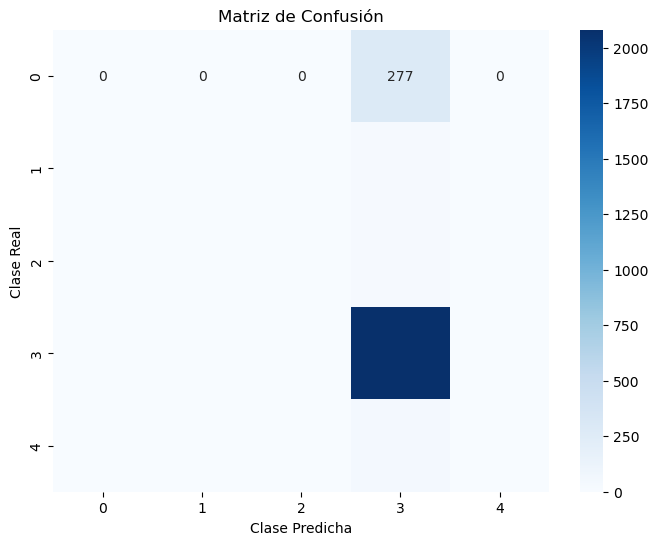

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       277
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        32
           3       0.85      1.00      0.92      2081
           4       0.00      0.00      0.00        41

    accuracy                           0.85      2456
   macro avg       0.17      0.20      0.18      2456
weighted avg       0.72      0.85      0.78      2456



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
matriz_confusion(modelo)

## Análisis de la problemática del dataset
Los resultados reflejados en el modelo presentan un resultado que refleja las consecuencia de un modelo entrenado con clases desbalanceadas con un recall del 100% para la clase mayoritaria (la clase 4 pero mostrada como la clase 3 por temas de muestreo y de la última capa densa del modelo) en comparación del resto de clases minoritarias donde estas tienen un 0% de recall por lo que el modelo no ha aprendido nada de los datos de entrenamiento y las predicciones son todas para la clase 4.

## Como podemos abordar este problema y mejorar el rendimiento del modelo

Dado el claro sesgo hacia la clase dominante y el bajo rendimiento en las clases minoritarias, se plantean las siguientes estrategias de mejora. Cada una aborda los problemas detectados y será explorada en los siguientes puntos del análisis.



## 1. Ajustar la Pérdida

El modelo actual utiliza una pérdida estándar (`sparse_categorical_crossentropy`), que trata a todas las clases por igual. Para mejorar la detección de clases minoritarias, se puede implementar una pérdida ponderada:

- **Pérdida Ponderada (*Class Weights*):**
  - Asignar un peso mayor a las clases con menor representación, penalizando más los errores en estas clases durante el entrenamiento.
  - TensorFlow permite configurar fácilmente los pesos de las clases utilizando un diccionario de pesos al entrenar el modelo.
  - Esto obliga al modelo a prestar mayor atención a las clases minoritarias, compensando el desbalance en los datos.

Esta técnica es especialmente útil en combinación con el reequilibrio de datos para maximizar el rendimiento en clases minoritarias.



## 2. Reequilibrar los Datos

El desbalance en los datos de entrenamiento está afectando significativamente el rendimiento del modelo. Para abordar este problema, se pueden utilizar las siguientes técnicas:

- **Sobremuestreo (Oversampling):**
  - Generar más ejemplos para las clases minoritarias replicando instancias existentes o utilizando técnicas de *data augmentation* específicas para texto, como la generación de sinónimos o el cambio de estructura de las frases.
  - Esto aumenta la representación de las clases minoritarias, mejorando la capacidad del modelo para aprender patrones relevantes.

- **Submuestreo (Undersampling):**
  - Reducir la cantidad de datos de la clase dominante seleccionando aleatoriamente una muestra representativa.
  - Aunque esto puede reducir la cantidad total de datos disponibles, ayuda a equilibrar las proporciones entre clases, disminuyendo el sesgo.

Ambas técnicas pueden ser utilizadas individualmente o combinadas para lograr un balance adecuado en los datos de entrenamiento.



## 3. Evaluar Otras Arquitecturas

La arquitectura actual, basada en una sola capa LSTM, puede no ser suficiente para manejar la complejidad de los datos desbalanceados. Se proponen las siguientes modificaciones:

- **Incluir Capas Adicionales:**
  - Agregar más capas LSTM  para capturar mejor las relaciones contextuales en el texto.
  - Incorporar capas densas adicionales para mejorar la capacidad de clasificación del modelo.

## 4. Ajuste en el enfoque del problema
Al tratarse de una variable objetivo con valores categóricos ordinales podemos tratar de hacer una predicción de regresión lineal donde se tratara de predecir la intensidad como un valor continuo entre los rangos de valores de los niveles de intensidad en lugar de como una clase.
## 5. Reduciendo la dimensionalidad
Como última alternativa se analiza los patrones en el dataset y se da una solución tratando de reducir la dimensionalidad de las clases a predecir dentro de nuestro dataset. Se busca mejorar el modelo reduciendo las clases objetivo a aquellas que muestren patrones dentro de sus datos.

---

## 1. Ajustar la Pérdida
Este código implementa la estrategia de **ajustar la pérdida mediante pesos de clase** para abordar el problema de desbalance en los datos. A continuación, se explica cada paso del flujo:


In [22]:
from sklearn.utils.class_weight import compute_class_weight
# Calcular los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

modelo_v2 = crear_modelo_lstm(vocab_size=1000)

# Entrenar el modelo con los pesos de clase
history_v2 = modelo_v2.fit(train_dataset, epochs=10, validation_data=test_dataset, class_weight=class_weight_dict)

Epoch 1/10


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3488 - loss: 1.5068 - val_accuracy: 0.0098 - val_loss: 1.6771
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.1508 - loss: 1.5971 - val_accuracy: 0.0130 - val_loss: 1.6204
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.0823 - loss: 1.6410 - val_accuracy: 0.8473 - val_loss: 1.4996
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.3399 - loss: 1.5467 - val_accuracy: 0.0167 - val_loss: 1.6463
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.1568 - loss: 1.5886 - val_accuracy: 0.0167 - val_loss: 1.6249
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.1069 - loss: 1.6681 - val_accuracy: 0.8469 - val_loss: 1.5756
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.2726 - loss: 1.6376 - val_accuracy: 0.8469 - val_loss: 1.5967
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3065 - loss: 1.5903 - val_accuracy: 0.01

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


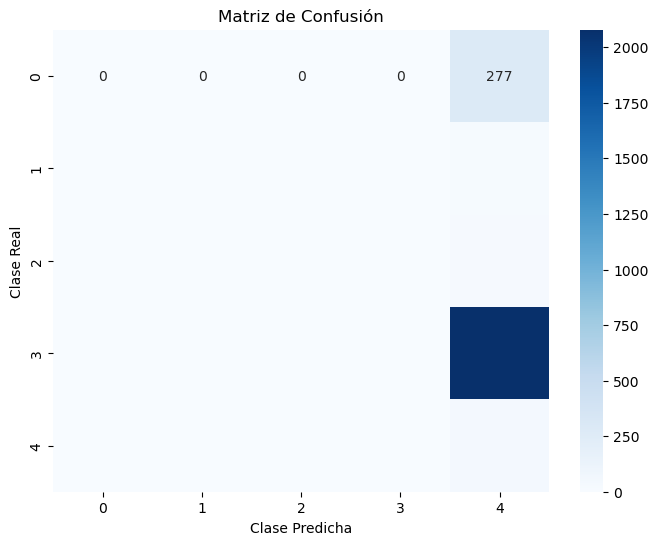

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       277
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        32
           3       0.50      0.00      0.00      2081
           4       0.02      1.00      0.03        41

    accuracy                           0.02      2456
   macro avg       0.10      0.20      0.01      2456
weighted avg       0.42      0.02      0.00      2456



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
matriz_confusion(modelo_v2)

## resultado del ajuste de los pesos de las clases en el entrenamiento
 Con una accuracy del 2% nos refleja que el modelo no es capaz de aprender nada de los datos aunque estén ponderados los pesos en aprendizaje para que este aprenda del resto de clases, en este caso el modelo aprende que para todos estos forman parte de la segunda clase mayoritaria en este caso la clase 5 la cual tiene un recall del 100% pero un acierto del 2% indicadnos que el modelo no ha aprendido nada

--- 
#   2. Reequilibrar los datos

Este tercer planteamiento se plantea un oversampling de las clases minoritarias para observar si de esta forma el modelo es capaz de aprender.

In [24]:
from sklearn.utils import resample

# Crear un DataFrame con los datos de entrenamiento
train_data = pd.DataFrame(X_train)
train_data['label'] = y_train

# Identificar las clases minoritarias y mayoritarias
minority_class = train_data[train_data['label'] != 3]  # Cambiar 3 por la clase mayoritaria
majority_class = train_data[train_data['label'] == 3]

# Sobremuestrear las clases minoritarias
minority_class_oversampled = resample(minority_class,
                                      replace=True,  # Permite duplicar las muestras
                                      n_samples=len(majority_class),  # Ajustar al tamaño de la clase mayoritaria
                                      random_state=42)

# Combinar las clases minoritarias sobremuestreadas con la clase mayoritaria
train_balanced = pd.concat([majority_class, minority_class_oversampled])

# Verificar la distribución de clases balanceada
print(train_balanced['label'].value_counts())

# Aquí debes separar X (características) y y (etiquetas)
X_balanced = train_balanced[0]  # Suponiendo que 'mensaje' es la columna de texto
y_balanced = train_balanced['label']

# Preprocesar y tokenizar el texto usando TextVectorization
vectorizador = tf.keras.layers.TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=100)

# Adaptar el vectorizador a los datos
vectorizador.adapt(X_balanced)

# Convertir las entradas de texto en secuencias de índices
X_balanced_vectorized = vectorizador(X_balanced)

# Convertir a un array de NumPy con el tipo de datos correcto
X_balanced_array = np.array(X_balanced_vectorized, dtype=np.int32)  # Asegúrate de que el tipo sea np.int32
y_balanced_array = np.array(y_balanced, dtype=np.int32)  # Asegúrate de que el tipo sea np.int32

# Ahora que X_balanced_array y y_balanced_array están en formato NumPy, podemos crear un nuevo dataset
train_balanced_dataset = tf.data.Dataset.from_tensor_slices((X_balanced_array, y_balanced_array))

# Configuramos el batching y prefetching para optimizar el rendimiento
train_balanced_dataset = train_balanced_dataset.shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)


label
3    8293
0    5908
4     907
2     791
1     687
Name: count, dtype: int64


Con esto logramos incrementar el número de registros en las clases minoritarias obteniendo así casi seis veces más datos respecto a los datos originales.

In [25]:
modelo_v3 = crear_modelo_lstm(vocab_size=1000)

# Entrenar el modelo con los pesos de clase
history_v3 = modelo_v3.fit(train_balanced_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.5969 - loss: 1.0792 - val_accuracy: 0.1128 - val_loss: 0.9850
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5666 - loss: 1.0517 - val_accuracy: 0.8473 - val_loss: 0.9336
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5892 - loss: 1.0524 - val_accuracy: 0.1128 - val_loss: 0.9678
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5607 - loss: 1.0573 - val_accuracy: 0.8473 - val_loss: 0.9117
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5989 - loss: 1.0399 - val_accuracy: 0.8473 - val_loss: 0.9378
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6064 - loss: 1.0530 - val_accuracy: 0.8469 - val_loss: 0.9592
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5825 - loss: 1.0633 - val_accuracy: 0.8473 - val_loss: 0.9320
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5928 - loss: 1.0597 - val_accurac

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


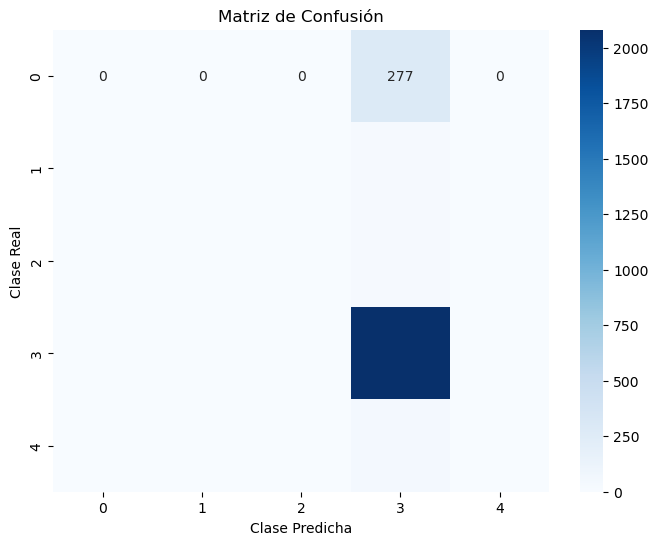

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       277
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        32
           3       0.85      1.00      0.92      2081
           4       0.00      0.00      0.00        41

    accuracy                           0.85      2456
   macro avg       0.17      0.20      0.18      2456
weighted avg       0.72      0.85      0.78      2456



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
matriz_confusion(modelo_v3)

# Resultado del oversampling
La matriz de confusión refleja que no ha habido ningún cambio respecto al balanceo original de los datos y que el modelo sigue sin aprender ningún patron en los datos

--- 
#   Oversampling + ajuste de pesos en las clases durante el entrenamiento

In [27]:
modelo_v4 = crear_modelo_lstm(vocab_size=1000)

# Calcular los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_balanced), y=y_balanced)
class_weight_dict = dict(enumerate(class_weights))

# Entrenar el modelo con los pesos de clase
history_v4 = modelo_v4.fit(train_balanced_dataset, epochs=10, validation_data=test_dataset, class_weight=class_weight_dict)

Epoch 1/10


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.4780 - loss: 1.3708 - val_accuracy: 0.0167 - val_loss: 1.8572
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.3716 - loss: 1.4033 - val_accuracy: 0.1128 - val_loss: 1.7613
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4039 - loss: 1.3928 - val_accuracy: 0.1128 - val_loss: 1.8159
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.3822 - loss: 1.4037 - val_accuracy: 0.1128 - val_loss: 1.8145
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3900 - loss: 1.3979 - val_accuracy: 0.0130 - val_loss: 1.7659
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.3972 - loss: 1.4081 - val_accuracy: 0.1132 - val_loss: 1.7257
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4271 - loss: 1.3986 - val_accuracy: 0.0179 - val_loss: 1.7768
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3594 - loss: 1.4055 - val_accuracy

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


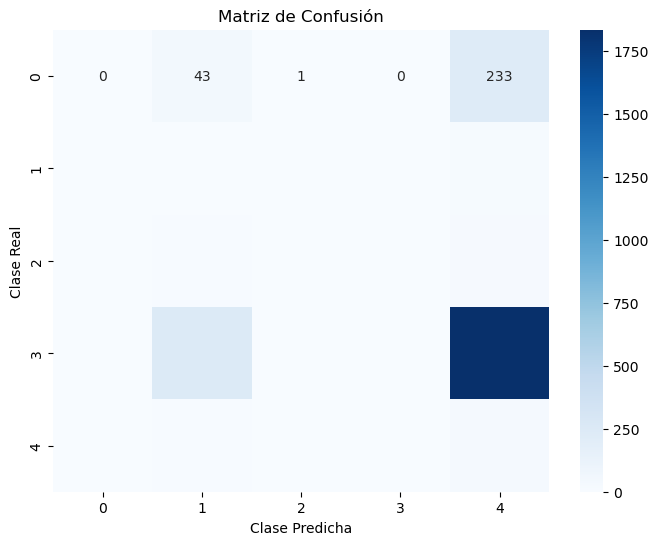

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       277
           1       0.02      0.20      0.03        25
           2       0.33      0.03      0.06        32
           3       0.00      0.00      0.00      2081
           4       0.02      0.80      0.03        41

    accuracy                           0.02      2456
   macro avg       0.07      0.21      0.02      2456
weighted avg       0.00      0.02      0.00      2456



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
matriz_confusion(modelo_v4)

# Resultado

El modelo trata de aprender a no clasificar para la clase mayoritaria (Clase 4) pero este es incapaz de encontrar un patron en los datos por lo que no ajusta los pesos a una clase de forma correcta, dando como resultado en una tasa de acierto del 2%.

---
#   Undersampling
Si el incremento de las clases minoritarias no es suficiente para encontrar los patrones para el resto de clases, vamos a observar como afectaría es reducimos la clase mayoritaria en lugar de aumentar el resto de clases

In [29]:
# Separar las clases
majority_class = train_data[train_data['label'] == 3]  # Asumimos que 4 es la clase mayoritaria
minority_classes = train_data[train_data['label'] != 3]

# Reducir la clase mayoritaria para que tenga el mismo número de muestras que las minoritarias
majority_class_downsampled = resample(majority_class,
                                      replace=False,    # Sin reemplazo
                                      n_samples=len(minority_classes),  # Igualar el tamaño
                                      random_state=42)

# Combinar las clases minoritarias con la clase mayoritaria balanceada
train_balanced = pd.concat([majority_class_downsampled, minority_classes])

# Verificar la distribución de clases balanceada
print(train_balanced['label'].value_counts())

# Aquí debes separar X (características) y y (etiquetas)
X_balanced = train_balanced[0]  # Suponiendo que 'mensaje' es la columna de texto
y_balanced = train_balanced['label']

# Preprocesar y tokenizar el texto usando TextVectorization
vectorizador = tf.keras.layers.TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=100)

# Adaptar el vectorizador a los datos
vectorizador.adapt(X_balanced)

# Convertir las entradas de texto en secuencias de índices
X_balanced_vectorized = vectorizador(X_balanced)

# Convertir a un array de NumPy con el tipo de datos correcto
X_balanced_array = np.array(X_balanced_vectorized, dtype=np.int32)  # Asegúrate de que el tipo sea np.int32
y_balanced_array = np.array(y_balanced, dtype=np.int32)  # Asegúrate de que el tipo sea np.int32

# Ahora que X_balanced_array y y_balanced_array están en formato NumPy, podemos crear un nuevo dataset
train_balanced_dataset = tf.data.Dataset.from_tensor_slices((X_balanced_array, y_balanced_array))

# Configuramos el batching y prefetching para optimizar el rendimiento
train_balanced_dataset = train_balanced_dataset.shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)



label
3    1530
0    1098
4     169
2     140
1     123
Name: count, dtype: int64


In [30]:
modelo_v5 = crear_modelo_lstm(vocab_size=1000)

# Entrenar el modelo con los pesos de clase
history_v5 = modelo_v5.fit(train_balanced_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.4394 - loss: 1.3333 - val_accuracy: 0.8473 - val_loss: 0.8959
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4839 - loss: 1.1708 - val_accuracy: 0.8473 - val_loss: 0.8253
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5011 - loss: 1.1439 - val_accuracy: 0.8473 - val_loss: 0.8154
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4712 - loss: 1.1839 - val_accuracy: 0.8473 - val_loss: 0.8045
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5086 - loss: 1.1505 - val_accuracy: 0.8473 - val_loss: 0.8613
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5056 - loss: 1.1699 - val_accuracy: 0.8473 - val_loss: 0.8317
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5021 - loss: 1.1445 - val_accuracy: 0.8473 - val_loss: 0.8367
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4944 - loss: 1.1677 - val_accuracy: 0.8473 - val_loss: 0.

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


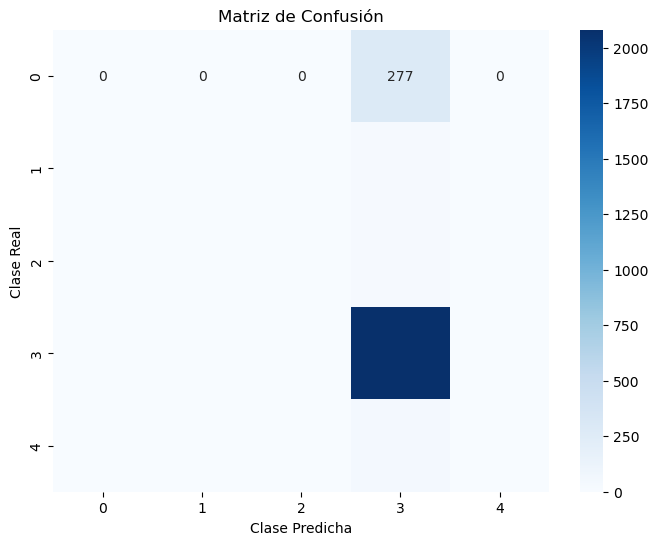

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       277
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        32
           3       0.85      1.00      0.92      2081
           4       0.00      0.00      0.00        41

    accuracy                           0.85      2456
   macro avg       0.17      0.20      0.18      2456
weighted avg       0.72      0.85      0.78      2456



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
matriz_confusion(modelo_v5)

#   Resultado Undersampling
El modelo sigue sin aprender nada sobre el resto de las clases y predice en todos los casos que para cualquier entrada de datos estos serán para el nivel 4 de intensidad de odio

--- 
#   Undersampling + ajuste de pesos

In [32]:
modelo_v6 = crear_modelo_lstm(vocab_size=1000)

# Calcular los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_balanced), y=y_balanced)
class_weight_dict = dict(enumerate(class_weights))

# Entrenar el modelo con los pesos de clase
history_v6 = modelo_v6.fit(train_balanced_dataset, epochs=10, validation_data=test_dataset, class_weight=class_weight_dict)

Epoch 1/10


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.1211 - loss: 1.6521 - val_accuracy: 0.8469 - val_loss: 1.5505
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3173 - loss: 1.5991 - val_accuracy: 0.0098 - val_loss: 1.6103
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2389 - loss: 1.5871 - val_accuracy: 0.0098 - val_loss: 1.6394
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.0689 - loss: 1.6236 - val_accuracy: 0.0098 - val_loss: 1.6100
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.2880 - loss: 1.5934 - val_accuracy: 0.0098 - val_loss: 1.6116
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.2461 - loss: 1.5656 - val_accuracy: 0.0167 - val_loss: 1.6115
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1272 - loss: 1.5792 - val_accuracy: 0.1128 - val_loss: 1.6092
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2939 - loss: 1.5726 - val_accuracy: 0.0167 - val_loss: 1.

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


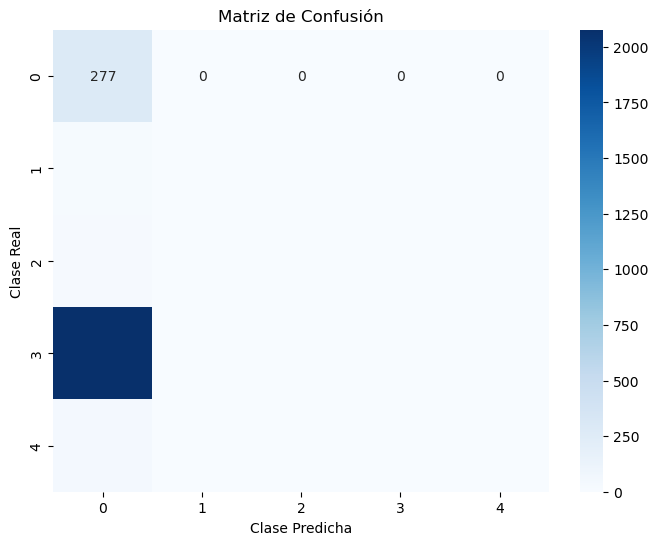

              precision    recall  f1-score   support

           0       0.11      1.00      0.20       277
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        32
           3       1.00      0.00      0.00      2081
           4       0.00      0.00      0.00        41

    accuracy                           0.11      2456
   macro avg       0.22      0.20      0.04      2456
weighted avg       0.86      0.11      0.02      2456



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
matriz_confusion(modelo_v6)

#   Resultado
Ofrece una mejora sobre la configuración de oversampling con ajuste de pesos pero con una aprendizaje del 10% de los datos no podemos confirmar que esta configuración sea la acertada

---
#   3. Mejora en la arquitectura

# Mejoras en la Arquitectura del Modelo LSTM

El modelo original ha sido mejorado mediante la inclusión de nuevas capas y técnicas de regularización, con el objetivo de aumentar su capacidad de generalización y mejorar su rendimiento en tareas de clasificación multiclase. A continuación, se describen los cambios y mejoras implementados:

## Aumento de la Capacidad de las LSTM
- **Mayor número de unidades LSTM**:
  - Se incrementó el número de unidades a 128 en la primera capa LSTM para capturar mejor las relaciones contextuales en el texto.
- **Capa Bidireccional**:
  - Las capas LSTM son ahora bidireccionales, lo que permite al modelo procesar información en ambas direcciones (hacia adelante y hacia atrás). Esto mejora la comprensión del contexto en las secuencias.
- **Capa LSTM adicional**:
  - Se añadió una segunda capa LSTM bidireccional con menos unidades (64) para capturar dependencias más complejas y específicas del texto.

## Mejoras en Regularización
- **Uso intensivo de Dropout**:
  - Se introdujo Dropout (con valores de 0.4) en múltiples puntos del modelo para reducir el riesgo de sobreajuste.
- **Batch Normalization**:
  - Se añadieron capas de Batch Normalization después de las densas para estabilizar y acelerar el proceso de entrenamiento, además de reducir la sensibilidad a la inicialización de los pesos.

## Incremento en el Poder de Modelado
- **Capas Densas Adicionales**:
  - Se incluyeron múltiples capas densas con un número mayor de neuronas (128, 64) y activaciones `ReLU`, lo que aumenta la capacidad del modelo para aprender características complejas.
- **Capa de Salida Softmax**:
  - La capa final sigue utilizando una activación `softmax`, adecuada para la clasificación multiclase.

## Optimizador Avanzado
- **Optimización con Nadam**:
  - El modelo ahora utiliza el optimizador Nadam (una variante de Adam), que combina el método de momento con tasas de aprendizaje adaptativas para mejorar la convergencia y rendimiento.

In [34]:
from tensorflow.keras import layers, models

def crear_modelo_lstm_mejorado(vocab_size, embedding_dim=100, lstm_units=128, num_classes=5):
    model = models.Sequential()
    
    # Capa de embedding
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100))
    
    # Capa LSTM con más unidades y return_sequences=True
    model.add(layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=True)))
    # Regularización con Dropout
    model.add(layers.Dropout(0.4))
    # Otra capa LSTM para capturar más dependencias
    model.add(layers.Bidirectional(layers.LSTM(units=lstm_units // 2, return_sequences=False)))  # Capa LSTM adicional
    
    # Capa densa con más neuronas y activación ReLU para más poder de modelado
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.4))  # Dropout adicional para evitar el sobreajuste

    # BatchNormalization para estabilizar el entrenamiento
    model.add(layers.BatchNormalization())

    # Capa densa con más neuronas y activación ReLU para más poder de modelado
    model.add(layers.Dense(64, activation='relu'))

    # BatchNormalization para estabilizar el entrenamiento
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))  # Dropout adicional para evitar el sobreajuste
    
    # Capa densa con más neuronas y activación ReLU para más poder de modelado
    model.add(layers.Dense(64, activation='relu'))
    
    # BatchNormalization para estabilizar el entrenamiento
    model.add(layers.BatchNormalization())
    
    # Capa de salida con activación softmax para clasificación multiclase
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compilamos el modelo con un optimizador Nadam
    model.compile(optimizer='Nadam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Crear el modelo mejorado
modelo_mejorado = crear_modelo_lstm_mejorado(vocab_size=1000)
modelo_mejorado.summary()


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Configuración de los datos

Dado que deseamos que el modelo aprenda del resto de clases partiremos de la configuración de datos que reflejaba un entrenamiento repartido entre las clases como era el caso tanto del oversampling como el undersampling con equilibrio en los pesos de las clases durante el entrenamiento. En este caso trabajaremos en la configuración undersampling

In [35]:
# Separar las clases
majority_class = train_data[train_data['label'] == 3]  # Asumimos que 4 es la clase mayoritaria
minority_classes = train_data[train_data['label'] != 3]

# Reducir la clase mayoritaria para que tenga el mismo número de muestras que las minoritarias
majority_class_downsampled = resample(majority_class,
                                      replace=False,    # Sin reemplazo
                                      n_samples=len(minority_classes),  # Igualar el tamaño
                                      random_state=42)

# Combinar las clases minoritarias con la clase mayoritaria balanceada
train_balanced = pd.concat([majority_class_downsampled, minority_classes])

# Verificar la distribución de clases balanceada
print(train_balanced['label'].value_counts())

# Aquí debes separar X (características) y y (etiquetas)
X_balanced = train_balanced[0]  # Suponiendo que 'mensaje' es la columna de texto
y_balanced = train_balanced['label']

# Preprocesar y tokenizar el texto usando TextVectorization
vectorizador = tf.keras.layers.TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=100)

# Adaptar el vectorizador a los datos
vectorizador.adapt(X_balanced)

# Convertir las entradas de texto en secuencias de índices
X_balanced_vectorized = vectorizador(X_balanced)

# Convertir a un array de NumPy con el tipo de datos correcto
X_balanced_array = np.array(X_balanced_vectorized, dtype=np.int32)  # Asegúrate de que el tipo sea np.int32
y_balanced_array = np.array(y_balanced, dtype=np.int32)  # Asegúrate de que el tipo sea np.int32

# Ahora que X_balanced_array y y_balanced_array están en formato NumPy, podemos crear un nuevo dataset
train_balanced_dataset = tf.data.Dataset.from_tensor_slices((X_balanced_array, y_balanced_array))

# Configuramos el batching y prefetching para optimizar el rendimiento
train_balanced_dataset = train_balanced_dataset.shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)

label
3    1530
0    1098
4     169
2     140
1     123
Name: count, dtype: int64


In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelo_v7 = crear_modelo_lstm_mejorado(vocab_size=1000)

# Calcular los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_balanced), y=y_balanced)
class_weight_dict = dict(enumerate(class_weights))
# Definir los callbacks
checkpoint_callback = ModelCheckpoint(
    'modelo_v7_mejorado.keras',           # Ruta para guardar el modelo
    monitor='val_accuracy',           # Monitoriza la precisión de validación
    save_best_only=True,              # Guarda solo el mejor modelo
    mode='max',                       # Se guarda cuando la métrica aumenta (maximizar val_accuracy)
    verbose=1                         # Muestra información cuando se guarda el modelo
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',           # Monitorea la precisión de validación
    patience=20,                        # Número de épocas sin mejora antes de detenerse
    restore_best_weights=True,         # Restablece los pesos del mejor modelo
    mode='max',                        # Para optimizar la precisión de validación
    verbose=1                          # Muestra información cuando se detiene el entrenamiento
)
# Entrenar el modelo con los pesos de clase
history_v7 = modelo_v7.fit(
    train_balanced_dataset,
    epochs=100,
    validation_data=test_dataset,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback, early_stopping_callback] 
)

Epoch 1/100


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.2104 - loss: 2.1024
Epoch 1: val_accuracy improved from -inf to 0.84731, saving model to modelo_v7_mejorado.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.2105 - loss: 2.1012 - val_accuracy: 0.8473 - val_loss: 1.3344
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.2117 - loss: 1.9082
Epoch 2: val_accuracy did not improve from 0.84731
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.2115 - loss: 1.9083 - val_accuracy: 0.8473 - val_loss: 1.2706
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.2060 - loss: 1.8452
Epoch 3: val_accuracy did not improve from 0.84731
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.2059 - loss: 1.8448 - val_accuracy: 0.6030 - val_loss: 1.2827
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2178 - loss: 1.6938
Epoch 4: val_accuracy did not improve from 0.84731
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.2178 - 

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step


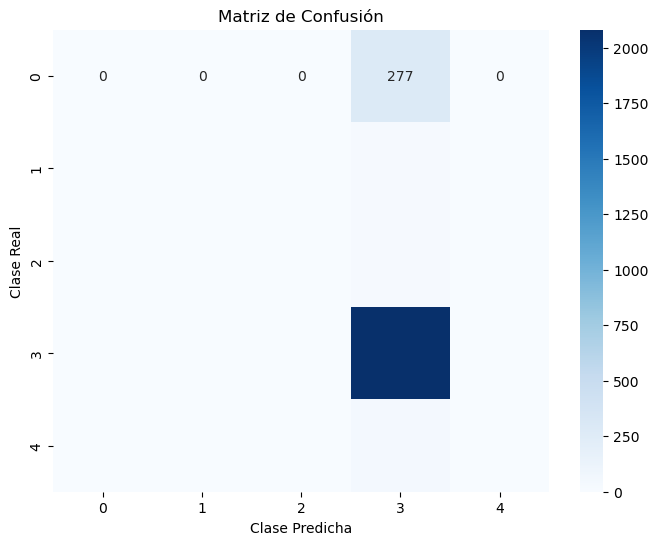

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       277
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        32
           3       0.85      1.00      0.92      2081
           4       0.00      0.00      0.00        41

    accuracy                           0.85      2456
   macro avg       0.17      0.20      0.18      2456
weighted avg       0.72      0.85      0.78      2456



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
matriz_confusion(modelo_v7)

# Resultado
El modelo sigue sin aprender ningún patron del resto de clases

# 4. Modelo Red neuronal recurrente con regresión lineal
Para ello se trata la variable a predecir como un float y se altera la cap de salida como una sola neurona de activación lineal lo cual nos permite tratar de predecir el valor numérico.

In [39]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Separar los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesar y tokenizar el texto usando TextVectorization
vectorizador = tf.keras.layers.TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=100)

# Adaptar el vectorizador a los datos de entrenamiento
vectorizador.adapt(X_train)

# Convertir las entradas de texto en secuencias de índices
X_train_vectorized = vectorizador(X_train)
X_test_vectorized = vectorizador(X_test)

# Convertir las etiquetas a arrays NumPy
y_train_array = np.array(y_train, dtype=np.float32)
y_test_array = np.array(y_test, dtype=np.float32)

# Crear el Dataset de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train_array)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test_array)).batch(64).prefetch(tf.data.AUTOTUNE)

# Definir el modelo LSTM para regresión
def crear_modelo_lstm_regresion(vocab_size, embedding_dim=100, lstm_units=128):
    model = models.Sequential()
    
    # Capa de embedding
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100))
    
    # Capa LSTM bidireccional
    model.add(layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=False)))

    # Dropout para evitar sobreajuste
    model.add(layers.Dropout(0.4))
    
    # Capa densa para regresión
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))
    # Capa densa para regresión
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))  # Salida continua
    
    # Compilamos el modelo
    model.compile(optimizer='adam', 
                  loss='mean_squared_error',  # Para regresión, usamos MSE como función de pérdida
                  metrics=['mean_absolute_error'])  # MAE como métrica adicional
    
    return model

# Crear el modelo
vocab_size = 1000  # Número máximo de palabras del vectorizador
modelo_v8 = crear_modelo_lstm_regresion(vocab_size)

# Resumen del modelo
modelo_v8.summary()

# Entrenar el modelo
history_v8 = modelo_v8.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    verbose=1
)

# Evaluar el modelo
loss, mae = modelo_v8.evaluate(test_dataset)
print(f"Mean Absolute Error (MAE) en el conjunto de prueba: {mae:.4f}")

# Predicción
y_pred = modelo_v8.predict(test_dataset)

# Calcular métricas de evaluación adicionales
mse = mean_squared_error(y_test_array, y_pred)
mae = mean_absolute_error(y_test_array, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - loss: 3.4836 - mean_absolute_error: 1.4157 - val_loss: 0.9976 - val_mean_absolute_error: 0.8228
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - loss: 1.1342 - mean_absolute_error: 0.7683 - val_loss: 1.3323 - val_mean_absolute_error: 1.1013
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - loss: 0.9106 - mean_absolute_error: 0.7024 - val_loss: 1.6860 - val_mean_absolute_error: 1.2508
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - loss: 0.8266 - mean_absolute_error: 0.6674 - val_loss: 1.6714 - val_mean_absolute_error: 1.2423
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - loss: 0.7546 - mean_absolute_error: 0.6289 - val_loss: 1.5451 - val_mean_absolute_error: 1.1904
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - loss: 0.6976 - mean_absolute_error: 0.5905 - val_loss: 1.3432 - val_mean_absolute_error: 1.0885
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - loss: 0.6375 - mean_abs

## Resultados 
- **Mean Squared Error (MSE): 0.9956**
  - Este valor indica el error cuadrático promedio entre las predicciones del modelo y los valores reales. Un valor cercano a 1 es razonablemente bajo en el contexto de una escala de 5 clases (ordenadas entre 0 y 4).

- **Mean Absolute Error (MAE): 0.4399**
  - Este valor mide el error promedio en términos absolutos. En este caso, el error promedio por predicción es inferior a 0.5, lo que implica que las predicciones suelen estar, en promedio, a menos de media clase de distancia del valor real.

# Modelo de regresión lineal con incremento en las capas LSTM y el número de neuronas en la capa densa

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Separar los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesar y tokenizar el texto usando TextVectorization
vectorizador = tf.keras.layers.TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=100)

# Adaptar el vectorizador a los datos de entrenamiento
vectorizador.adapt(X_train)

# Convertir las entradas de texto en secuencias de índices
X_train_vectorized = vectorizador(X_train)
X_test_vectorized = vectorizador(X_test)

# Convertir las etiquetas a arrays NumPy
y_train_array = np.array(y_train, dtype=np.float32)
y_test_array = np.array(y_test, dtype=np.float32)

# Crear el Dataset de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train_array)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test_array)).batch(64).prefetch(tf.data.AUTOTUNE)

# Definir el modelo LSTM para regresión
def crear_modelo_lstm_regresion(vocab_size, embedding_dim=100,  lstm_units=256):
    model = models.Sequential()

    # Capa de embedding
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100))

    # Capa LSTM bidireccional
    model.add(layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=True)))

    # Añadir más capas LSTM bidireccionales para aumentar la capacidad
    model.add(layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(units=lstm_units // 2, return_sequences=False)))

    # Dropout para evitar sobreajuste
    model.add(layers.Dropout(0.5))

    # Capa densa adicional para regresión
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))

    # Capa de salida continua
    model.add(layers.Dense(1, activation='linear'))  # Salida continua para regresión

    # Compilamos el modelo con Adam y ajustamos la tasa de aprendizaje
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',  # Para regresión, usamos MSE como función de pérdida
                  metrics=['mean_absolute_error'])  # MAE como métrica adicional

    return model


# Crear el modelo
vocab_size = 1000  # Número máximo de palabras del vectorizador
modelo_v9 = crear_modelo_lstm_regresion(vocab_size)

# Resumen del modelo
modelo_v8.summary()

early_stopping_callback = EarlyStopping(
    monitor='val_mean_absolute_error',           # Monitorea la precisión de validación
    patience=50,                        # Número de épocas sin mejora antes de detenerse
    restore_best_weights=True,         # Restablece los pesos del mejor modelo
    mode='min',                        # Para optimizar la precisión de validación
    verbose=1                          # Muestra información cuando se detiene el entrenamiento
)

# Entrenar el modelo
history_v9 = modelo_v9.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Evaluar el modelo
loss, mae = modelo_v9.evaluate(test_dataset)
print(f"Mean Absolute Error (MAE) en el conjunto de prueba: {mae:.4f}")

# Predicción
y_pred = modelo_v9.predict(test_dataset)

# Calcular métricas de evaluación adicionales
mse = mean_squared_error(y_test_array, y_pred)
mae = mean_absolute_error(y_test_array, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 100)       │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,065,509 (4.06 MB)

 Trainable params: 355,169 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 710,340 (2.71 MB)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 164s 974ms/step - loss: 4.4231 - mean_absolute_error: 1.1380 - val_loss: 2.0602 - val_mean_absolute_error: 0.8983
Epoch 2/100


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


154/154 ━━━━━━━━━━━━━━━━━━━━ 151s 982ms/step - loss: 2.0513 - mean_absolute_error: 0.7985 - val_loss: 1.3176 - val_mean_absolute_error: 0.5861
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - loss: 1.4385 - mean_absolute_error: 0.7237 - val_loss: 1.1304 - val_mean_absolute_error: 0.5891
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - loss: 1.1041 - mean_absolute_error: 0.6468 - val_loss: 0.9863 - val_mean_absolute_error: 0.5640
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - loss: 0.9261 - mean_absolute_error: 0.6059 - val_loss: 0.8933 - val_mean_absolute_error: 0.4796
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - loss: 0.8212 - mean_absolute_error: 0.5797 - val_loss: 0.8868 - val_mean_absolute_error: 0.5009
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - loss: 0.7375 - mean_absolute_error: 0.5512 - val_loss: 0.8255 - val_mean_absolute_error: 0.4801
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 0.6879 - mean_absolute_error: 0.537

## Resultados del Entrenamiento y Predicción

- **Mean Squared Error (MSE): 0.8100**
  - Este valor indica el error cuadrático promedio entre las predicciones del modelo y los valores reales. Un MSE de 0.8100 es una mejora respecto al valor anterior, lo que sugiere que las predicciones están más cerca de los valores reales en promedio. Dado que el modelo es tratado como regresión, este valor relativamente bajo indica que el modelo está capturando bien las relaciones entre las clases ordenadas.

- **Mean Absolute Error (MAE): 0.3917**
  - El MAE de 0.3917 significa que, en promedio, las predicciones están a menos de 0.4 clases de distancia de los valores reales. Este es un buen resultado, ya que un error promedio tan bajo refleja que el modelo está haciendo predicciones bastante precisas, lo que es importante, especialmente al tratarse de un problema de regresión con clases ordinales.

Estos resultados sugieren que el modelo ha mejorado su capacidad para predecir valores más cercanos a la realidad, especialmente considerando la naturaleza ordinal de las clases.


# 5 Reducción de dimensionalidad
## Análisis en las palabras usada por clase
El código realiza un análisis para calcular el porcentaje de las 100 palabras más frecuentes en las clases minoritarias (0, 1, 2, 4) que también están presentes en las 100 palabras más frecuentes de la clase mayoritaria (clase 3) de un dataset. Primero, se filtran los mensajes de cada clase y se utiliza `CountVectorizer` para obtener las palabras más frecuentes en los mensajes de la clase mayoritaria. Luego, para cada clase minoritaria, se calcula cuántas de sus 100 palabras más frecuentes también están presentes entre las 100 palabras más frecuentes de la clase mayoritaria. El resultado se representa en un gráfico de barras, donde cada barra muestra el porcentaje de coincidencia de las palabras entre la clase mayoritaria y las clases minoritarias, proporcionando una visión de cómo se solapan las palabras entre las clases y si existe una relación significativa entre ellas. Este análisis puede ser útil para entender mejor la distribución y la superposición de características textuales entre las clases en el dataset.


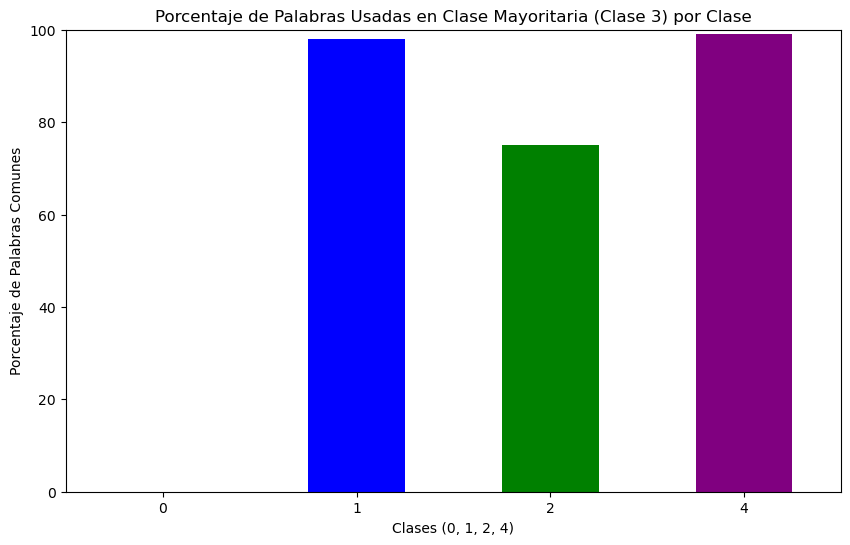

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Filtramos los mensajes por clase mayoritaria (clase 3) y otras clases
class_3_messages = data[data['intensidad'] == 3]['mensaje']
other_classes_messages = data[data['intensidad'] != 3]

# Usamos CountVectorizer para obtener las 100 palabras más frecuentes en la clase mayoritaria (clase 3)
vectorizer = CountVectorizer(stop_words='english', max_features=100)
X_class_3 = vectorizer.fit_transform(class_3_messages)

# Obtenemos las 100 palabras más frecuentes de la clase 3
class_3_words = vectorizer.get_feature_names_out()

# Convertimos a un DataFrame para facilitar el análisis
class_3_word_counts = X_class_3.toarray().sum(axis=0)
word_frequency_class_3 = pd.DataFrame(list(zip(class_3_words, class_3_word_counts)), columns=['Word', 'Frequency'])

# Ahora vamos a calcular para cada clase (0, 1, 2, 4) el porcentaje de sus 100 palabras más frecuentes que también aparecen en la clase mayoritaria

# Inicializamos un diccionario para guardar los porcentajes de cada clase
class_percentages = {}

# Para cada clase (0, 1, 2, 4)
for i in range(5):
    if i != 3:
        class_messages = data[data['intensidad'] == i]['mensaje']
        X_class = vectorizer.transform(class_messages)

        # Obtenemos la frecuencia de las 100 palabras en esta clase
        word_frequency_class = X_class.toarray().sum(axis=0)

        # Calculamos el porcentaje de palabras de esta clase que aparecen en la clase mayoritaria
        common_words_count = sum(word_frequency_class_3['Word'].isin(class_3_words) & (word_frequency_class > 0))
        total_class_3_words = len(class_3_words)

        # Calculamos el porcentaje de coincidencia
        percentage = (common_words_count / total_class_3_words) * 100
        class_percentages[i] = percentage

# Convertimos los resultados en un DataFrame para facilitar la visualización
class_percentages_df = pd.DataFrame(list(class_percentages.items()), columns=['Class', 'Percentage_in_Class_3'])
class_percentages_df.set_index('Class', inplace=True)

# Graficamos los resultados
plt.figure(figsize=(10, 6))
class_percentages_df['Percentage_in_Class_3'].plot(kind='bar', color=['red', 'blue', 'green', 'purple'])
plt.title("Porcentaje de Palabras Usadas en Clase Mayoritaria (Clase 3) por Clase")
plt.xlabel("Clases (0, 1, 2, 4)")
plt.ylabel("Porcentaje de Palabras Comunes")
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.show()


Observando el resultado podemos detectar como claramente el resto de clases minoritarias ha excepción de la clase 1 (representada con el valor 0) usan casi las mismas palabras que la clase mayoritaria haciendo de esto que los patrones para que puedan aprender a distinguir las clases entre sí muy complejas. Ha excepción de la clase 1 este no usa ninguna de las 100 palabras más usadas por la clase mayoritaria observando. Tras este análisis y ver que existirían patrones distintivos entre la clase 1 y el resto veamos como trabajaría con estos resultados un modelo RNN de clasificación binaria entre estos dos grupos.

## 5.1 RNN con predicción binaria de los datos - Reducción de dimensionalidad
Para este punto podríamos aplicar algoritmos como RPA o T-SNE pero hemos optado tras el análisis los datos, juntar las dimensiones parecidas entre si manteniendo de esta forma la interpretabilidad de los datos.

In [51]:
from sklearn.model_selection import train_test_split
import numpy as np

# Separar las instancias de clase 0
X_class_0 = X[y == 1]
y_class_0 = y[y == 1]

# Separar el resto de las clases (1 a 4)
X_non_0 = X[y != 1]
y_non_0 = y[y != 1]
# Verificar cuántas instancias existen para la clase 0
print(f"Total de instancias con clase 1: {np.sum(y == 1)}")
print(f"Total de instancias con clases 2-5: {np.sum(y != 1)}")
print("Cantidad de ejemplos de cada clase:")
print(np.bincount(y))
# Dividir las instancias de clase 0 en entrenamiento y prueba
X_train_class_0, X_test_class_0, y_train_class_0, y_test_class_0 = train_test_split(X_class_0, y_class_0, test_size=0.2, random_state=42)

# Dividir las instancias de las clases 1-4 en entrenamiento y prueba
X_train_non_0, X_test_non_0, y_train_non_0, y_test_non_0 = train_test_split(X_non_0, y_non_0, test_size=0.2, random_state=42)

# Ahora, concatenamos las instancias de clase 0 y las de clase 1-4
X_train = np.concatenate([X_train_class_0, X_train_non_0])
y_train = np.concatenate([y_train_class_0, y_train_non_0])

X_test = np.concatenate([X_test_class_0, X_test_non_0])
y_test = np.concatenate([y_test_class_0, y_test_non_0])

# Reordenar los datos para que la mezcla sea aleatoria
indices_train = np.random.permutation(len(X_train))
X_train = X_train[indices_train]
y_train = y_train[indices_train]

indices_test = np.random.permutation(len(X_test))
X_test = X_test[indices_test]
y_test = y_test[indices_test]

# Verificar la distribución de clases en ambos conjuntos
print("Distribución de clases en y_train:", np.bincount(y_train))
print("Distribución de clases en y_test:", np.bincount(y_test))


Total de instancias con clase 1: 1375
Total de instancias con clases 2-5: 10904
Cantidad de ejemplos de cada clase:
[    0  1375   148   172 10374   210]
Distribución de clases en y_train: [   0 1100  114  143 8297  169]
Distribución de clases en y_test: [   0  275   34   29 2077   41]


C:\Users\GenisPc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 31s 164ms/step - accuracy: 0.8787 - loss: 0.3963 - val_accuracy: 0.9011 - val_loss: 0.2799
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 166ms/step - accuracy: 0.9064 - loss: 0.2447 - val_accuracy: 0.8950 - val_loss: 0.2781
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - accuracy: 0.9180 - loss: 0.2105 - val_accuracy: 0.8884 - val_loss: 0.2935
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - accuracy: 0.9231 - loss: 0.1973 - val_accuracy: 0.8831 - val_loss: 0.3105
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 166ms/step - accuracy: 0.9295 - loss: 0.1875 - val_accuracy: 0.8876 - val_loss: 0.3226
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.9331 - loss: 0.1731 - val_accuracy: 0.8929 - val_loss: 0.3491
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - accuracy: 0.9424 - loss: 0.1587 - val_accuracy: 0.8921 - val_loss: 0.3500
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 166ms/step - accuracy: 0.9467 - loss: 0

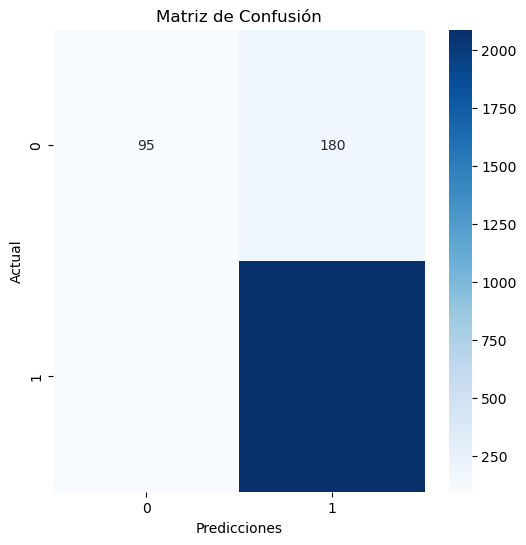

              precision    recall  f1-score   support

         0.0       0.50      0.35      0.41       275
         1.0       0.92      0.96      0.94      2181

    accuracy                           0.89      2456
   macro avg       0.71      0.65      0.67      2456
weighted avg       0.87      0.89      0.88      2456



In [52]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Separar los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convertir las etiquetas a 0 para clase 0, y 1 para clases 1-4 (binario)
y_train_bin = np.where(y_train == 1, 0, 1)  # Mantener clase 0 igual y convertir 1-4 a 1
y_test_bin = np.where(y_test == 1, 0, 1)

# Preprocesar y tokenizar el texto usando TextVectorization
vectorizador = tf.keras.layers.TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=100)

# Adaptar el vectorizador a los datos de entrenamiento
vectorizador.adapt(X_train)

# Convertir las entradas de texto en secuencias de índices
X_train_vectorized = vectorizador(X_train)
X_test_vectorized = vectorizador(X_test)

# Convertir las etiquetas a arrays NumPy
y_train_array = np.array(y_train_bin, dtype=np.float32)
y_test_array = np.array(y_test_bin, dtype=np.float32)

# Crear el Dataset de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train_array)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test_array)).batch(64).prefetch(tf.data.AUTOTUNE)

# Definir el modelo LSTM para clasificación binaria
def crear_modelo_lstm_binario(vocab_size, embedding_dim=100, lstm_units=128):
    model = models.Sequential()
    
    # Capa de embedding
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100))
    
    # Capa LSTM bidireccional
    model.add(layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=False)))

    # Dropout para evitar sobreajuste
    model.add(layers.Dropout(0.4))
    
    # Capa densa para clasificación binaria
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))
    
    # Capa de salida con activación sigmoide para clasificación binaria
    model.add(layers.Dense(1, activation='sigmoid'))  # Salida binaria
    
    # Compilamos el modelo
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',  # Usamos binary cross-entropy para clasificación binaria
                  metrics=['accuracy'])  # Usamos precisión como métrica
    
    return model

# Crear el modelo
vocab_size = 1000  # Número máximo de palabras del vectorizador
modelo_binario = crear_modelo_lstm_binario(vocab_size)

# Resumen del modelo
modelo_binario.summary()

# Entrenar el modelo
history_binario = modelo_binario.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,  # Ajusta el número de épocas según lo necesites
    verbose=1
)

# Evaluar el modelo
loss, accuracy = modelo_binario.evaluate(test_dataset)
print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")

# Predicción
y_pred = modelo_binario.predict(test_dataset)

# Convertir las predicciones en clases 0 o 1 directamente
y_pred_bin = (y_pred > 0.5).astype(int)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_array, y_pred_bin)

# Mostrar la matriz de confusión como un heatmap
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Actual")
plt.show()

# Imprimir reporte de clasificación con métricas como precisión, recall y F1-score
print(classification_report(y_test_array, y_pred_bin))


## Conclusión 
Los resultados obtenidos en este proyecto ofrecen una visión clara de las dificultades y posibles soluciones al problema del desbalance de clases en modelos de clasificación, y cómo la transformación del problema en una tarea de regresión puede ser una alternativa eficaz. Dando como respuesta a que en un problema con la dimensionalidad reducida como modelo con una precisión del 89% y con una clara demostración de que el modelo ha aprendido algunos de los patrones entre las clases que en comparación a la resta de modelos donde estos no aprendían nada es un gran salto.

### Análisis de los Resultados
1. **Modelos de Clasificación y Desbalance de Clases**:
   - Los intentos previos con modelos de clasificación no lograron aprender patrones significativos debido al fuerte desbalance de clases en los datos. Las clases minoritarias no tuvieron suficiente representación, lo que llevó a que el modelo predominara hacia la clase mayoritaria, sin capturar adecuadamente las diferencias entre las clases menores.
   - Esto es un problema común en tareas de clasificación con datos desbalanceados, donde el modelo tiende a predecir la clase mayoritaria y, por lo tanto, falla en generalizar correctamente a las clases minoritarias.

2. **Regresión como Alternativa Eficaz**:
   - Al transformar la variable objetivo en valores continuos (floats) y tratar el problema como una regresión lineal, se permitió que el modelo capturara las relaciones ordinales entre las clases. Este enfoque mostró un **Mean Squared Error (MSE) de 0.8100** y un **Mean Absolute Error (MAE) de 0.3917**, lo que sugiere que las predicciones del modelo fueron significativamente más cercanas a los valores reales que en los modelos de clasificación.
   - La regresión permite al modelo manejar la naturaleza ordenada de las clases de manera más eficiente, evitando los problemas causados por el desbalanceo, ya que no necesita tratar las clases como entidades discretas. En su lugar, el modelo predice un valor continuo y, a partir de él, se puede inferir la clase correspondiente.

3. **Desbalance de Datos y Su Impacto**:
   - El desbalance de clases en los datos sigue siendo un desafío, pero al tratar el problema como regresión, el impacto de este desbalance se reduce. Esto ocurre porque la regresión no se ve tan afectada por la disparidad en la frecuencia de las clases, lo que permite al modelo aprender de manera más equilibrada sobre todas las clases, incluidas las minoritarias.

4. **Reducción de dimensionalidad**
   -  Al reducir la dimensionalidad por grupos donde estos tienen claras diferencias en las palabras usadas, esto hace que el modelo pueda aprender patrones distintivos entre estos grupos aunque exista una clara diferencia en el balance de registros entre estos grupos por lo que el modelo no termina aprender lo suficiente sobre la clase minoritaria.

### Reflexión Final
Dado que los modelos de clasificación no pudieron captar los patrones debido al desbalance de clases, el enfoque de regresión ofrece una **mejor solución en este contexto**. Al modelar las clases como una variable continua y aprovechar su naturaleza ordinal, el modelo logró hacer predicciones más precisas y equilibradas. Tras una analisis más en profundidad se logra encontrar un solución donde se demuestra que el modelo ha logrado aprender parte de los patrones al reducir la dimensionalidad aunque este no logre predicciones del todo fiables en la clase minoritaria.

Este resultado resalta la importancia de **adaptar la estrategia de modelado al tipo de problema y a las características de los datos**. El uso de regresión lineal para tratar un problema de clasificación con clases ordenadas es una alternativa prometedora, especialmente cuando el desbalance de clases es un factor relevante y la reducción de la dimensionalidad un claro acierto para ajustar los datos a patrones existentes entre los grupos.